<a href="https://colab.research.google.com/github/Hisbulahh/UAS-SIG-Prediksi-Banjir/blob/main/Prediksi-Banjir-Sumsel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================================
# SEL 1: INSTALASI DAN IMPORT LIBRARY
# ==============================================================================
# Instalasi library yang mungkin belum ada di Colab (seperti xgboost)
!pip install pandas scikit-learn matplotlib seaborn geopandas xgboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import zipfile
import os

# Model dan Metrik dari Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Model XGBoost
from xgboost import XGBClassifier

# Untuk upload file di Colab
from google.colab import files

# Untuk legenda peta
import matplotlib.patches as mpatches

print("Library berhasil diimport.")

Library berhasil diimport.


In [ ]:
# ==============================================================================
# SEL 2 (VERSI FINAL): MENGGABUNGKAN DATA DENGAN NAMA KOLOM BERBEDA
# ==============================================================================
print("\n--- Tahap 2: Memuat dan Menggabungkan Data ---")
print("Silakan upload 2 file lagi: 'penggunaan_lahan_sumsel.csv' DAN 'riwayat_banjir_sumsel.csv'")

# Upload kedua file
uploaded = files.upload()

# Membaca data dari masing-masing file
df_lahan = pd.read_csv("penggunaan_lahan_sumsel.csv")
df_banjir = pd.read_csv("riwayat_banjir_sumsel.csv")

print("\nFile berhasil dimuat.")
print("Kolom data lahan:", df_lahan.columns.tolist())
print("Kolom data banjir:", df_banjir.columns.tolist())


# --- INI BAGIAN YANG DIPERBAIKI ---
# Kita menggunakan 'left_on' untuk tabel kiri (df_lahan) dan 'right_on' untuk tabel kanan (df_banjir)
kolom_kunci_lahan = 'Kabupaten/Kota'  # Nama kolom di file penggunaan lahan
kolom_kunci_banjir = 'Lokasi'         # Nama kolom di file riwayat banjir

try:
    df = pd.merge(df_lahan, df_banjir, left_on=kolom_kunci_lahan, right_on=kolom_kunci_banjir, how='left')

    # Membuat kolom target "Pernah Banjir"
    # Logikanya: Jika sebuah lokasi ada di file riwayat_banjir_sumsel.csv, maka kita anggap 'Pernah Banjir' (nilai 1).
    # Jika tidak ada (setelah merge nilainya NaN/kosong), kita anggap 'Tidak Pernah' (nilai 0).
    # Kita bisa menggunakan salah satu kolom dari df_banjir (misal 'ID' atau 'Tahun') untuk pengecekan ini.
    df['Pernah Banjir'] = np.where(df[kolom_kunci_banjir].notna(), 1, 0)


    print("\nData berhasil digabungkan:")
    # Menampilkan kolom kunci dan kolom target yang baru dibuat untuk verifikasi
    print(df[['Kabupaten/Kota', 'Lokasi', 'Pernah Banjir']].head(17)) # Tampilkan semua baris untuk cek

except Exception as e:
    print(f"\nTERJADI ERROR: {e}")
    print(">>> Pastikan nama kolom di variabel 'kolom_kunci_lahan' dan 'kolom_kunci_banjir' sudah benar.")


--- Tahap 2: Memuat dan Menggabungkan Data ---
Silakan upload 2 file lagi: 'penggunaan_lahan_sumsel.csv' DAN 'riwayat_banjir_sumsel.csv'


Saving penggunaan_lahan_sumsel.csv to penggunaan_lahan_sumsel (6).csv
Saving riwayat_banjir_sumsel.csv to riwayat_banjir_sumsel (2).csv

File berhasil dimuat.
Kolom data lahan: ['Kabupaten/Kota', 'Lahan Sawah (ha)', 'Lahan Permukiman (ha)', 'Lahan Perkebunan (ha)', 'Lahan Hutan (ha)', 'Lahan Terbuka (ha)', 'Total Luas Penggunaan Lahan (ha)']
Kolom data banjir: ['ID', 'Lokasi', 'Tahun', 'Bulan', 'Ketinggian Air (cm)', 'Jumlah KK Terdampak', 'Tingkat Kerusakan']

Data berhasil digabungkan:
                Kabupaten/Kota                      Lokasi  Pernah Banjir
0               Kota Palembang                         NaN              0
1            Kota Lubuklinggau           Kota Lubuklinggau              1
2              Kota Prabumulih             Kota Prabumulih              1
3              Kota Pagar Alam             Kota Pagar Alam              1
4          Kabupaten Banyuasin         Kabupaten Banyuasin              1
5          Kabupaten Banyuasin         Kabupaten Banyuasin     

In [ ]:
# ==============================================================================
# SEL 3: FEATURE ENGINEERING (Membuat Fitur Baru)
# ==============================================================================
print("\n--- Tahap 3: Feature Engineering ---")

# Membuat salinan dataframe untuk fitur baru
df_engineered = df.copy()

# Menghitung fitur persentase untuk setiap jenis lahan
# Ini akan membuat model lebih memahami proporsi, bukan hanya nilai absolut
df_engineered['%_Sawah'] = (df_engineered['Lahan Sawah (ha)'] / df_engineered['Total Luas Penggunaan Lahan (ha)']) * 100
df_engineered['%_Permukiman'] = (df_engineered['Lahan Permukiman (ha)'] / df_engineered['Total Luas Penggunaan Lahan (ha)']) * 100
df_engineered['%_Perkebunan'] = (df_engineered['Lahan Perkebunan (ha)'] / df_engineered['Total Luas Penggunaan Lahan (ha)']) * 100
df_engineered['%_Hutan'] = (df_engineered['Lahan Hutan (ha)'] / df_engineered['Total Luas Penggunaan Lahan (ha)']) * 100
df_engineered['%_Terbuka'] = (df_engineered['Lahan Terbuka (ha)'] / df_engineered['Total Luas Penggunaan Lahan (ha)']) * 100

print("\nData dengan fitur baru (persentase):")
print(df_engineered[['Kabupaten/Kota', '%_Hutan', '%_Permukiman', 'Pernah Banjir']].head())


--- Tahap 3: Feature Engineering ---

Data dengan fitur baru (persentase):
        Kabupaten/Kota    %_Hutan  %_Permukiman  Pernah Banjir
0       Kota Palembang  22.305235     12.474810              0
1    Kota Lubuklinggau  15.365403     14.165490              1
2      Kota Prabumulih  26.788144     16.470449              1
3      Kota Pagar Alam   7.685597     19.363549              1
4  Kabupaten Banyuasin  28.086962     29.945323              1



--- Tahap 4: Eksplorasi Data Awal (EDA) ---


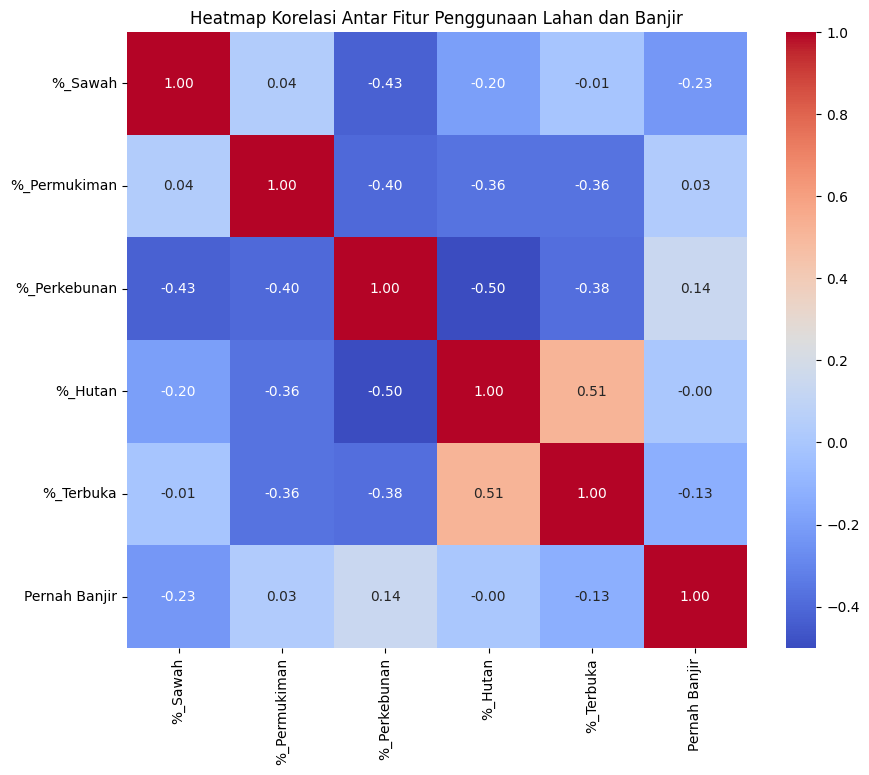

In [ ]:
# ==============================================================================
# SEL 4: EKSPLORASI DATA AWAL (EDA)
# ==============================================================================
print("\n--- Tahap 4: Eksplorasi Data Awal (EDA) ---")

# Membuat heatmap korelasi untuk melihat hubungan antar fitur
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_engineered[['%_Sawah', '%_Permukiman', '%_Perkebunan', '%_Hutan', '%_Terbuka', 'Pernah Banjir']].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title("Heatmap Korelasi Antar Fitur Penggunaan Lahan dan Banjir")
plt.show()

In [ ]:
# ==============================================================================
# SEL 5: PEMISAHAN DATA & PERBANDINGAN MODEL
# ==============================================================================
print("\n--- Tahap 5: Perbandingan Model Klasifikasi ---")

# Memilih fitur (X) dan target (y)
# Kita akan menggunakan fitur persentase yang baru dibuat
features = ['%_Sawah', '%_Permukiman', '%_Perkebunan', '%_Hutan', '%_Terbuka']
X = df_engineered[features]
y = df_engineered['Pernah Banjir']

# Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Daftar model yang akan diuji
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Melakukan iterasi untuk melatih dan mengevaluasi setiap model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"Model: {name}, Akurasi: {accuracy:.4f}")

# Menemukan model terbaik berdasarkan akurasi
best_model_name = max(results, key=results.get)
print(f"\nModel terbaik adalah: {best_model_name} dengan akurasi {results[best_model_name]:.4f}")


--- Tahap 5: Perbandingan Model Klasifikasi ---
Model: Random Forest, Akurasi: 0.8750
Model: Gradient Boosting, Akurasi: 0.6250
Model: SVM, Akurasi: 0.8750
Model: XGBoost, Akurasi: 1.0000

Model terbaik adalah: XGBoost dengan akurasi 1.0000


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:56:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# ==============================================================================
# SEL 6: HYPERPARAMETER TUNING UNTUK MODEL TERBAIK
# ==============================================================================
print(f"\n--- Tahap 6: Hyperparameter Tuning untuk {best_model_name} ---")

# Definisikan parameter grid untuk model terbaik (contoh untuk Random Forest)
# Anda bisa menyesuaikan ini jika model terbaiknya adalah yang lain
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Gunakan GridSearchCV untuk mencari parameter terbaik
best_model_instance = models[best_model_name]
grid_search = GridSearchCV(estimator=best_model_instance, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"\nParameter terbaik ditemukan: {grid_search.best_params_}")


--- Tahap 6: Hyperparameter Tuning untuk XGBoost ---
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Parameter terbaik ditemukan: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:56:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Tahap 7: Evaluasi Model Final ---

Laporan Klasifikasi Model Final:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         7

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

Matriks Konfusi:


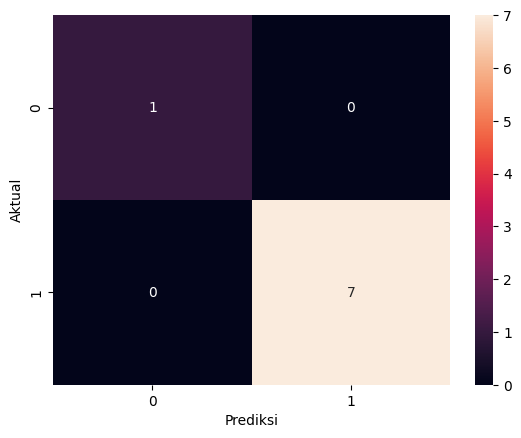

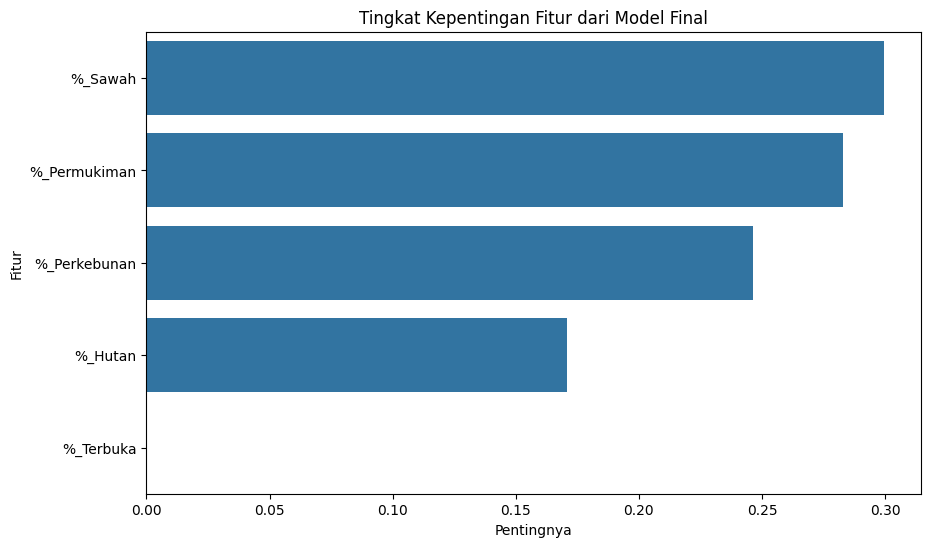

In [ ]:
# ==============================================================================
# SEL 7: EVALUASI MODEL FINAL YANG SUDAH DI-TUNE
# ==============================================================================
print("\n--- Tahap 7: Evaluasi Model Final ---")

# Gunakan model dengan parameter terbaik untuk prediksi
final_model = grid_search.best_estimator_
y_final_pred = final_model.predict(X_test)

print("\nLaporan Klasifikasi Model Final:")
print(classification_report(y_test, y_final_pred))

print("Matriks Konfusi:")
sns.heatmap(confusion_matrix(y_test, y_final_pred), annot=True, fmt='g')
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

# Menampilkan Feature Importance
importances = final_model.feature_importances_
feature_imp_df = pd.DataFrame({'Fitur': features, 'Pentingnya': importances}).sort_values('Pentingnya', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Pentingnya', y='Fitur', data=feature_imp_df)
plt.title('Tingkat Kepentingan Fitur dari Model Final')
plt.show()


--- Tahap 8: Membuat Peta Prediksi ---
Silakan upload file shapefile .zip untuk Sumatera Selatan (contoh: sumsel_admin.zip)


Saving sumsel admin.zip to sumsel admin (1).zip

Shapefile berhasil dimuat. Kolom tersedia: Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry'],
      dtype='object')


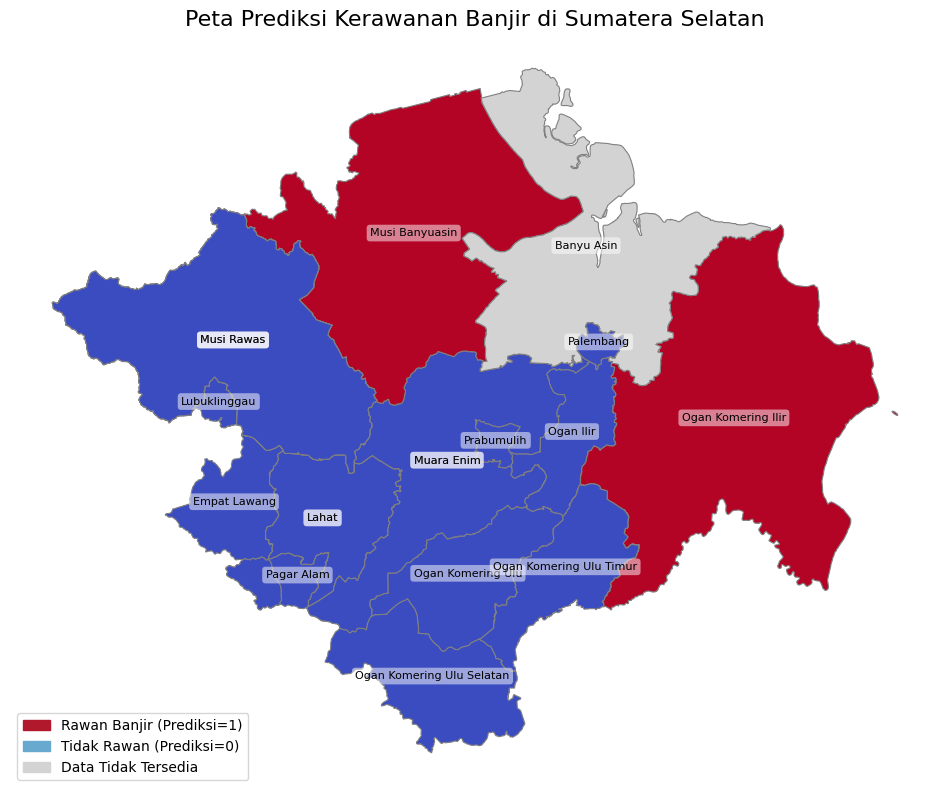


--- Analisis Selesai ---


In [ ]:
# ==============================================================================
# SEL 8: VISUALISASI PETA PREDIKSI KERAWAWANAN BANJIR
# ==============================================================================
print("\n--- Tahap 8: Membuat Peta Prediksi ---")

# 1. Muat data spasial (Shapefile)
print("Silakan upload file shapefile .zip untuk Sumatera Selatan (contoh: sumsel_admin.zip)")
uploaded_shp = files.upload()
zip_filename_shp = list(uploaded_shp.keys())[0]

extract_dir = "shapefile_sumsel"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_filename_shp, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Fungsi untuk mencari file .shp di dalam folder hasil ekstrak
def find_shp(directory):
    for root, dirs, files_in_dir in os.walk(directory):
        for file in files_in_dir:
            if file.endswith('.shp'):
                return os.path.join(root, file)
    return None

shp_path = find_shp(extract_dir)
if shp_path:
    gdf = gpd.read_file(shp_path)
    print("\nShapefile berhasil dimuat. Kolom tersedia:", gdf.columns)
else:
    print("\nERROR: File .shp tidak ditemukan dalam file ZIP yang diupload.")
    gdf = None

if gdf is not None:
    # 2. Buat prediksi untuk seluruh dataset
    df_engineered['Prediksi Banjir'] = final_model.predict(df_engineered[features])

    # 3. Gabungkan data prediksi dengan data geospasial (GeoDataFrame)
    def clean_name(name):
        return name.lower().replace('kabupaten ', '').replace('kota ', '').strip()

    df_engineered['Kabupaten_Clean'] = df_engineered['Kabupaten/Kota'].apply(clean_name)

    # --- PENTING: Sesuaikan nama kolom di shapefile Anda ---
    # Ganti 'NAME_2' di bawah ini jika nama kolomnya berbeda di shapefile Anda.
    col_kabupaten_shp = None
    if 'NAME_2' in gdf.columns:
        col_kabupaten_shp = 'NAME_2'
    elif 'Kabupaten' in gdf.columns:
        col_kabupaten_shp = 'Kabupaten'
    elif 'WADMKK' in gdf.columns:
        col_kabupaten_shp = 'WADMKK'

    if col_kabupaten_shp:
        gdf['Kabupaten_Clean'] = gdf[col_kabupaten_shp].str.lower().apply(clean_name)
        gdf_merged = gdf.merge(df_engineered, on='Kabupaten_Clean', how='left')
    else:
        print("PERINGATAN: Kolom nama kabupaten tidak ditemukan di shapefile. Peta tidak dapat dibuat.")
        gdf_merged = None

    if gdf_merged is not None:
        # 4. Buat peta choropleth
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))

        gdf_merged.plot(
            column='Prediksi Banjir',
            cmap='coolwarm_r', # Skema warna: merah (rawan) ke biru (aman)
            linewidth=0.8,
            ax=ax,
            edgecolor='0.5',
            legend=False,
            missing_kwds={ "color": "lightgrey", "label": "Data Tidak Tersedia" }
        )

        # Tambahkan label nama kabupaten di peta
        gdf_merged.apply(
            lambda x: ax.annotate(
                text=x[col_kabupaten_shp],
                xy=x.geometry.centroid.coords[0],
                ha='center',
                fontsize=8,
                bbox={"boxstyle": "round,pad=0.3", "fc": "white", "alpha": 0.5, "ec": "none"}
            ),
            axis=1
        )

        # Membuat legenda manual
        legend_patches = [
            mpatches.Patch(color='#b2182b', label='Rawan Banjir (Prediksi=1)'),
            mpatches.Patch(color='#67a9cf', label='Tidak Rawan (Prediksi=0)'),
            mpatches.Patch(color='lightgrey', label='Data Tidak Tersedia')
        ]

        ax.legend(handles=legend_patches, loc='lower left')
        ax.set_title("Peta Prediksi Kerawanan Banjir di Sumatera Selatan", fontsize=16)
        ax.set_axis_off()
        plt.show()
else:
    print("\nProses visualisasi peta dilewati karena shapefile tidak berhasil dimuat.")

print("\n--- Analisis Selesai ---")